# Movies Recommendation System with Item-Based Collaborative Filtering Approach


## Check List

- Import Dataset
    - [x] Read the dataset
- Dataset Visualization
    - [x] Visualize the ratings
    - [x] Visualize the threshold
- Data Preprocessing
    - [x] Merge Movies and Ratings tables
    - [x] Compress Sparesed Rows - Convert data to csr matrix
- Feature Extraction
    - [x] Choose the features
- Model Training
    - [x] Train KNN with K = 11 (10 simmilar movies + the movie itself) on the training data
    - [x] Load and Save the model.
- Recommendation 
    - [x] Recommendation function
- Results Visulaization Function
    - [x] Test with different movies names
- Test The Model
    - [x] Use the model to recommend movies
- GUI
    - [x] Run GUI script using streamlit

## Import Libraries

In [2]:
# Preprocessing
import os
import pandas as pd
import numpy as np

# Training
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving
import pickle

## Read The Dataset

In [3]:
root = os.path.join('..', 'ml-latest-small')

movies_df = pd.read_csv(os.path.join(root, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(root, "ratings.csv"))

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies_df.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [7]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


## Visualization

In [8]:
rates = ratings_df.groupby('rating')['rating'].agg('count')

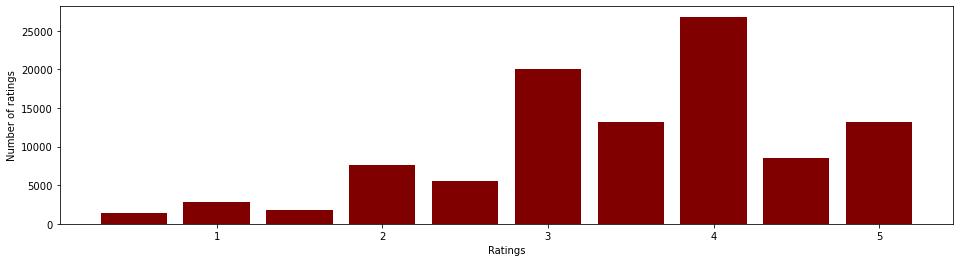

In [9]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.bar(rates.index, rates, width = 0.4, color ='maroon')
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.show()

In [10]:
users_rated = ratings_df.groupby('movieId')['rating'].agg('count')

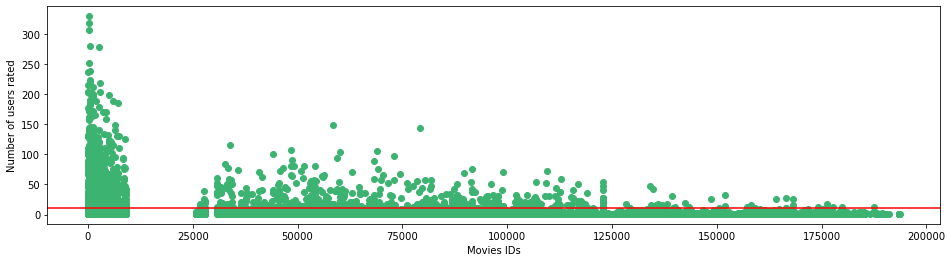

In [11]:

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(users_rated.index, users_rated,color='mediumseagreen')
plt.axhline(y=10, color='red')
plt.xlabel('Movies IDs')
plt.ylabel('Number of users rated')
plt.show()


In [12]:
movies_rated = ratings_df.groupby('userId')['rating'].agg('count')

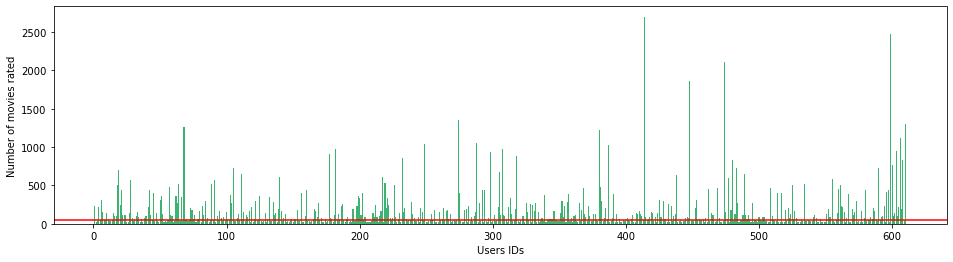

In [13]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.bar(movies_rated.index, movies_rated,color='mediumseagreen')
plt.axhline(y=50, color='red')
plt.xlabel('Users IDs')
plt.ylabel('Number of movies rated')
plt.show()


## Data Preprocessing

In [14]:
dataset = ratings_df.pivot(index='movieId',columns='userId',values='rating')
dataset.fillna(0,inplace=True)
dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
users_rated = ratings_df.groupby('movieId')['rating'].agg('count')
movies_rated = ratings_df.groupby('userId')['rating'].agg('count')

In [16]:
dataset = dataset.loc[users_rated[users_rated > 10].index,:]
dataset = dataset.loc[:,movies_rated[movies_rated > 50].index]
dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [19]:
# Compress Sparesed Rows
csr_data = csr_matrix(dataset.values)
dataset.reset_index(inplace=True)

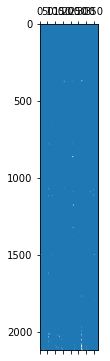

In [118]:
f,ax = plt.subplots(1,1,figsize=(10,6))
plt.spy(csr_data, markersize=1)
plt.show()


## Model Training - KNN with K = 20 and Cosine Simmilarity

In [119]:
def trainKNN(k, data):
    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
    knn.fit(data)
    
    return knn

In [120]:
k = 10
knn = trainKNN(k, csr_data)

## Model Saving

### Save

In [121]:
def saveModel(model_dir, model_name):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    model_path = os.path.join(model_dir, model_name)
    
    knn_file_w = open(model_path, 'wb')
    pickle.dump(knn, knn_file_w)
    knn_file_w.close()

In [122]:
model_dir = os.path.join('..', 'Models')
model_name = 'movies-recommender.knn.pkl'

saveModel(model_dir, model_name)

### Load

In [123]:
def loadModel(model_path, k):
    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
    knn_file_r = open(model_path, 'rb')
    model = pickle.load(knn_file_r)
    knn_file_r.close()

    return model

In [124]:
model_path = os.path.join(model_dir, model_name)
k = 10
model = loadModel(model_path, k)

## Recommendation Function

In [125]:
def Recommend(model, movieName, n):
    """
        Recommend:          Recommends the closes n movies from the output of a KNN model trained on the MovieLens dataset.
        movieName (str):    The movie name required to get the closest n movies to.
        n (int):            The number of movies to get.
    """
    
    n += 1

    # get all movies conatins the movieName
    movies = movies_df[movies_df['title'].str.contains(movieName)]  

    # if there isn't any movie with "movieName"
    if len(movies) < 1:
        return str(movieName) + " movie doesn't exist in our data"

    # get the index of the first result
    movie_id = movies.iloc[0]['movieId']
    movie_index = dataset[dataset['movieId'] == movie_id].index[0]
    
    # get the name of the target movie
    target_movie = movies_df[movies_df['title'].str.contains(movieName)].iloc[0]
    target_movie = target_movie['title']
    
    
    # get the indices of the closest n neighbors from the results on the knn model
    # the indices are the movies positions in the dataset
    distances, indices = model.kneighbors(csr_data[movie_index],n_neighbors=n)    
    
    # sort the output of the knn
    closest_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    
    movies_to_recommend = []

    # get the movie name and add it to a list 
    for movie_prediction in reversed(closest_movie_indices):
        index = movie_prediction[0]
        distance = movie_prediction[1]

        # get the movie index
        movie_id = dataset.iloc[index]['movieId']
        movie_index = movies_df[movies_df['movieId'] == movie_id].index
        
        # get the movie name by movie index
        movie_name = movies_df.iloc[movie_index]['title'].values[0]
        
        # add movie name and distance from the original movie to the list
        movies_to_recommend.append({'Movie Name': movie_name,
                                    'Distance': distance})
       
    # create a data frame from the list
    df = pd.DataFrame(movies_to_recommend)

    return df, distances, indices, target_movie

## Visualization Function

In [126]:
def vis(x, y, data):
    fig = plt.figure(figsize = (20, 10))

    # plt the recommended movies
    plt.scatter(x, y)
    plt.xlabel("Index")
    plt.ylabel("Distance")

    # plt the target movie with different color
    plt.scatter(x[0],y[0], c ="green", s=50)

    # annotate the movies points with it's names
    for i, txt in enumerate(data):
        plt.annotate(txt, (x[i], y[i]))
    # connect all the recommended movies to the target movie (x[0], y[0])
    for i in range(len(x)):
        x_, y_ = [x[0], x[i]], [y[0], y[i]]
        plt.plot(x_, y_)
    
    plt.show()    

    return fig

## Testing

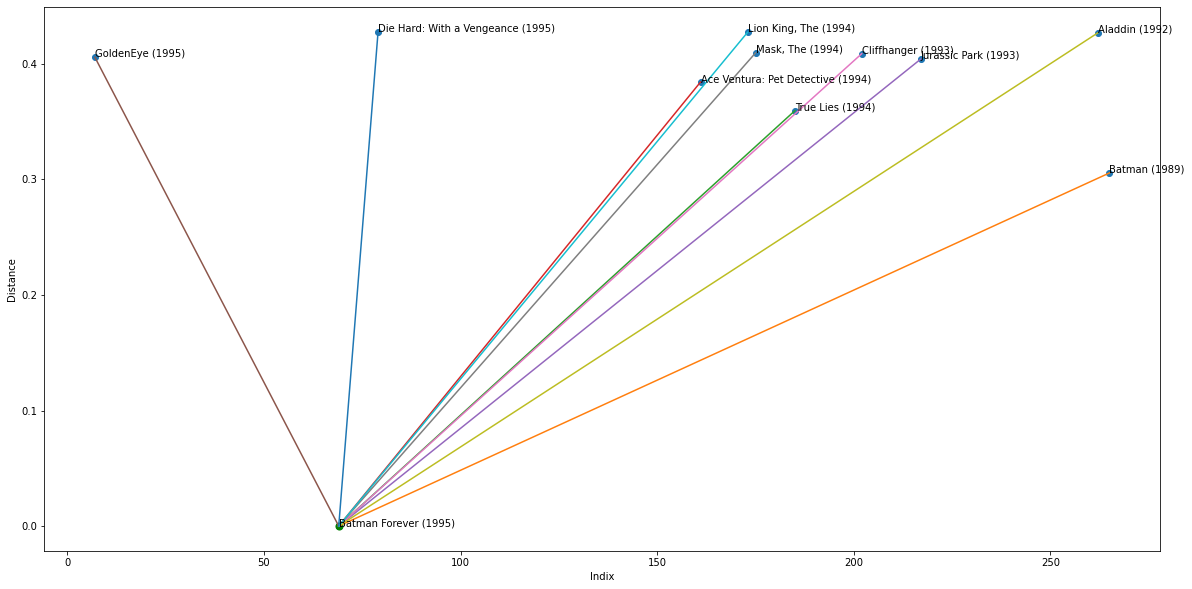

,Movie Name,Distance
0,Batman (1989),0.305549
1,True Lies (1994),0.359396
2,Ace Ventura: Pet Detective (1994),0.384173
3,Jurassic Park (1993),0.404032
4,GoldenEye (1995),0.405572
5,Cliffhanger (1993),0.408718
6,"Mask, The (1994)",0.409414
7,Aladdin (1992),0.426649
8,"Lion King, The (1994)",0.427317
9,Die Hard: With a Vengeance (1995),0.427554


In [128]:
movie_name = 'Batman'
n = 10

recommended, distances, indicies, target_movie = Recommend(model, movie_name, n)
x, y = indicies.reshape((indicies[0,:].shape[0])), distances.reshape((distances[0,:].shape[0]))

dat = recommended['Movie Name'].tolist()
#dat = [item.split("(")[0].split()[0] for item in dat]
dat.insert(0, target_movie)

vis(x, y, dat)
recommended


## GUI usign Streamlit

In [129]:
!cd .. && python3 main.py

2022-05-29 17:53:33.953 INFO    numexpr.utils: NumExpr defaulting to 4 threads.

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.15:8501

2022-05-29 17:54:29.647 Traceback (most recent call last):
  File "/home/dante/anaconda3/lib/python3.9/site-packages/streamlit/scriptrunner/script_runner.py", line 475, in _run_script
    exec(code, module.__dict__)
  File "/media/dante/New Volume/projects/nlp/Project/main.py", line 182, in <module>
    main()
  File "/media/dante/New Volume/projects/nlp/Project/main.py", line 158, in main
    success, recommended_movies, distances, indicies, target_movie = Recommend(model, data, csr_data, movies_df, movie_name, number_of_movies)
  File "/media/dante/New Volume/projects/nlp/Project/main.py", line 71, in Recommend
    movie_index = dataset[dataset['movieId'] == movie_id].index[0]
  File "/home/dante/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 4604, 